## Iterative Algorithm for Neo-K-Means

At the moment plots work only for 2 clusters, but the algorithm works for any.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.io import loadmat
from sklearn.metrics import f1_score # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
from sklearn.metrics.cluster import normalized_mutual_info_score # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html
from sklearn.decomposition import PCA
from numpy.random import choice
from numpy.random import seed
import networkx as nx

## K-Means++

In [5]:
def plot(data, centroids):
    plt.scatter(data[:, 0], data[:, 1], marker = '.',  
                color = 'gray', label = 'data points') 
    plt.scatter(centroids[:-1, 0], centroids[:-1, 1],  
                color = 'black', label = 'previously selected centroids') 
    plt.scatter(centroids[-1, 0], centroids[-1, 1],  
                color = 'red', label = 'next centroid') 
    plt.title('Select % d th centroid'%(centroids.shape[0])) 
      
    plt.legend() 
    plt.show() 

def initialize_kmeanspp(data, k, norm_p):
    ''' 
    initialize the centroids according to K-means++ 
    inputs: 
        data - numpy array of data points (input, features)
        k - number of clusters
        norm_p - order for L norm
    '''
    ## initialize the centroids list and add 
    ## a randomly selected data point to the list 
    centroids = [] 
    #centroids.append(np.random.randint(data.shape[0]))
    centroids.append(np.argmax(np.sum(data, axis=0)))

    ## compute remaining k - 1 centroids 
    for c_id in range(k - 1): 
        ## initialize a list to store distances of data 
        ## points from nearest centroid 
        dist = []
        for i in range(len(data)):
            min_dist = graph_dist(i, [centroids[0]])
            for c in centroids:
                min_dist = min(min_dist, graph_dist(i, [c]))
            dist.append(min_dist)

        ## select data point with maximum distance as our next centroid 
        dist = np.array(dist)**2 * np.sum(data, axis=0)
        
        centroids.append(np.random.choice(len(dist), p=dist/np.sum(dist)))
    #plot(data, np.array(centroids))
    return np.array(centroids)

### Datasets

In [13]:
dataset = 'zachary_unweighted.dat'
with open("datasets/graph_datasets/zachary/" + dataset, 'r') as f:
    adj_mat = np.array([np.array(l.split()).astype(int) for l in f.readlines()])

In [7]:
dataset = '0.edges'
with open("datasets/graph_datasets/facebook/" + dataset, 'r') as f:
    edge_mat = np.array([np.array(l.split()).astype(int) for l in f.readlines()])
adj_mat = np.zeros((np.max(edge_mat),np.max(edge_mat))).astype(int)
for v1,v2 in edge_mat:
    adj_mat[v1-1][v2-1] = 1
adj_mat[:,0] = 1
adj_mat[0,:] = 1
adj_mat[0,0] = 0

# not_connected = [v for v in range(len(adj_mat)) if np.sum(adj_mat[v]) == 0]
# for nc in not_connected[::-1]:
#     adj_mat = np.delete(np.delete(adj_mat, nc, 0), nc, 1)

In [14]:
def is_pos_def_eig(x):
    return np.all(np.linalg.eigvals(x) >= 0)
def is_pos_def_cholesky(x):
    try:
        np.linalg.cholesky(x)
        return True
    except:
        return False

def links_vc(v, C):
    return np.sum(adj_mat[v, C])
def links_cc(C):
    return np.sum(adj_mat[C][:,C])
def deg(x):
    if np.sum(adj_mat[x]) == 0:
        return 0.000000000001
    return np.sum(adj_mat[x])

def graph_dist(v, C):
    return -(2*links_vc(v,C)/(deg(v)*deg(C))) + (links_cc(C)/deg(C)**2) + (gamma/deg(v)) - (gamma/deg(C))

## Initializations

In [15]:
n = len(adj_mat) # no of vertices
k = 2 # cluster size 
norm_p = 2
algorithm = 'means' # means, medians, medoids

gamma = 0
while not is_pos_def_cholesky(adj_mat+np.identity(n)*gamma):
    gamma += 1

In [49]:
seed(4) #4

centroids = choice(len(adj_mat), size=k, replace=False)
#centroids = initialize_kmeanspp(adj_mat, k, norm_p)
#centroids = np.argsort(np.sum(adj_mat, axis=1))[::-1][:k]

alpha = 0.2 # np.sqrt(k)-1
beta = 0
sum_diff = 1
C_all = [[c] for c in centroids]
C_all

[[16], [21]]

In [46]:
C_all = np.array([[16], [23]])
centroids = np.array([16, 23])

## NEO-K-Ms

In [50]:
for t in range(50):
    old_centroids = centroids.copy()
            
    C_bar = [[] for _ in range(k)]
    C_hat = [[] for _ in range(k)]
    outliers = [i for i in range(n)]
    T = []
    S = []
    
    dists1 = np.array([[graph_dist(i, [c]) for c in centroids] for i in range(len(adj_mat))])**2
    dists2 = np.array([[graph_dist(i, C) for C in C_all] for i in range(len(adj_mat))])**2
    dists = dists1*dists2
            
    dists_argsorted = dists.flatten().argsort()
    p = 0
    i = 0
    while p < n-beta*n:
        pt_ind = dists_argsorted[i]
        if pt_ind//k not in S:
            C_bar[pt_ind%k].append(pt_ind//k)
            S.append(pt_ind//k)
            T.append((pt_ind//k, pt_ind%k))
            outliers.remove(pt_ind//k)
            p += 1
        i += 1
    
        
    i = 0
    while p < n+alpha*n:
        pt_ind = dists_argsorted[i]
        if ((pt_ind//k, pt_ind%k) not in T) and (pt_ind//k not in centroids):
            C_hat[pt_ind%k].append(pt_ind//k)
            T.append((pt_ind//k, pt_ind%k))
            if pt_ind//k in outliers:
                outliers.remove(pt_ind//k)
            p += 1
        i += 1
        
    C_all = [C_bar[i]+C_hat[i] for i in range(len(C_hat))]
    
    for i in range(k):
        other_centroids = set(centroids) - set([centroids[i]])
        old_avg_dissimilarity = avg_dissimilarity = graph_dist(centroids[i], C_all[i])**2

        for vertice in C_all[i]:
            new_dissimilarity= graph_dist(vertice, C_all[i])**2

            if (new_dissimilarity < avg_dissimilarity) and (vertice not in other_centroids):
                avg_dissimilarity = new_dissimilarity
                centroids[i] = vertice

        print("%f " % (old_avg_dissimilarity-avg_dissimilarity), end='')
    print("- " + str(centroids))
        
    if set(old_centroids) == set(centroids):
        break

5.950363 5.866404 - [33 32]
0.000000 0.067674 - [33  0]
0.000000 0.000000 - [33  0]


C:\Users\burak\Anaconda3\envs\datathon\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


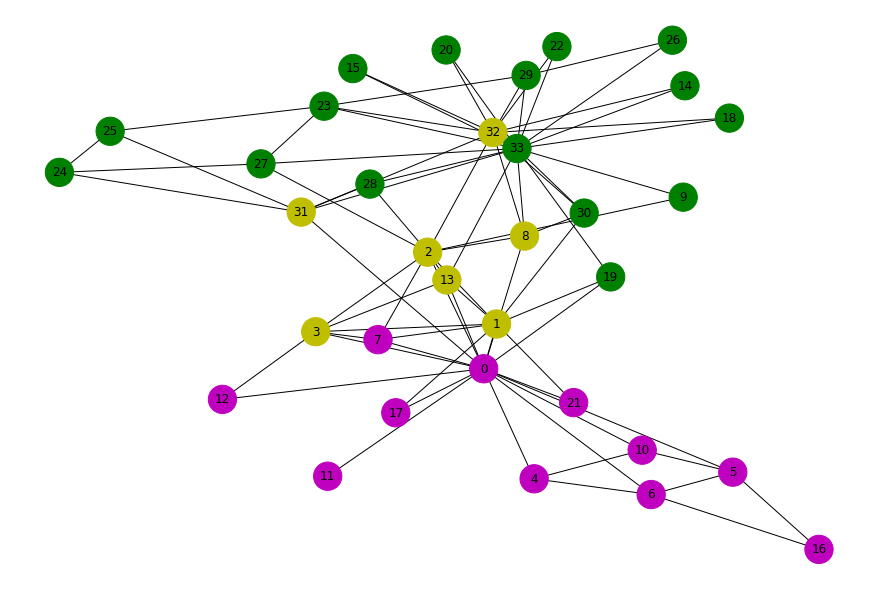

In [65]:
G = nx.from_pandas_adjacency(pd.DataFrame(adj_mat))

node_colors = np.array(['m']*len(adj_mat))
node_colors[C_all[0]] = 'g'
node_colors[list(set(C_all[0]).intersection(set(C_all[1])))] = 'y'

f = plt.figure(figsize=(12,8))
nx.draw(G, node_size=800, with_labels=True, node_color=node_colors)

plt.show()
f.savefig('karate2.pdf', bbox_inches='tight')